# Домашнее задание 3. 

# Коллаборативная фильтрация

[1. Матричная факторизация](#part1) 

[2. Alternating Least Squares (ALS)](#part2) 

[3. Взвешивание](#part3) 

[4. Поиск оптимальных параметров ALS](#part4) 

[5. Production](#part5) 

## 1. Матричная факторизация <a class="anchor" id="part1"></a><center>

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаро (латентый фактор = эмбеддинг (embedding))

<img src="mf.png" >

## 2. Alternating Least Squares (ALS) <a class="anchor" id="part2"></a><center>

<img src="als_formula.png" >

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать просто перемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 2.1. Загрузка и подготовка данных

Загрузка необходимых библиотек и модулей

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

#функции из домашнего задания 1
def precision_at_k(recommended_list, bought_list, k=5):
    
    recommended_list = np.array(recommended_list[:k])
    
    bought_list = np.array(bought_list)
        
    flags = np.isin(recommended_list, bought_list) * 1
    
    precision = flags.sum() / len(recommended_list) 
        
    return precision

Загрузка данных. Разбиение на train и test

In [134]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [135]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [136]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [137]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [138]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [139]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


### 2.2. Построение модели на основе ALS

In [140]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты (sales_value и quantity * sales_value дают чуть более лучшие результаты)
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [143]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=[itemid_to_id[999999]], 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 2.08 s


In [144]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

In [145]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
als_metric = result.apply(lambda row: precision_at_k(row['als'], row['actual'], 5), axis=1).mean()
als_metric

Wall time: 27.8 s


0.1829578844270295

In [146]:
result.head(3)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 1005186, 995242, 979707, 986912]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 914190, 822407, 938700]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[923746, 878996, 866211, 930118, 1024306]"


**Вывод:** получили бейзлайн ALS с метрикой precision@5 = 0.1829578844270295

### 2.3. Embeddings

Исслудем операции с эмбедингами и их результаты

In [148]:
model.item_factors.shape

(5001, 100)

In [149]:
model.user_factors.shape

(2499, 100)

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [150]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [151]:
pd.DataFrame(fast_recs)

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.013861,0.073698,-0.047091,-0.024744,0.007066,-0.003304,-0.001395,0.218650,0.053887,-0.047081,...,0.107154,0.167026,0.280567,0.174983,0.328557,0.060204,-0.085653,0.026126,0.034249,-0.060276
1,0.005566,0.048910,-0.024747,-0.008127,-0.002774,-0.005437,-0.007663,0.047800,0.096687,-0.042005,...,0.042201,0.011296,0.021228,0.097246,0.141765,0.074409,0.057866,-0.085950,0.049167,-0.002253
2,-0.013503,-0.081823,-0.054038,-0.041467,-0.016759,-0.021832,-0.027554,0.093791,0.025918,0.103056,...,-0.007989,0.004283,0.246252,0.176035,0.170435,0.321570,0.093567,-0.054005,0.048292,-0.034310
3,0.003784,0.069371,0.024981,0.049251,0.004197,0.010326,0.003217,0.125422,0.085590,0.009567,...,0.014293,0.083593,0.010177,-0.016403,0.054683,0.039216,0.028205,0.074808,0.014872,0.043976
4,-0.001273,0.023487,-0.011202,0.026749,0.001981,-0.001386,-0.002189,0.028462,0.038117,0.004683,...,-0.003483,0.008127,0.002830,0.058781,0.022577,-0.028098,0.032888,-0.012440,0.015396,-0.016001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.014680,0.128729,0.020721,0.010457,0.007893,0.015153,-0.009294,0.020686,-0.020866,-0.096485,...,0.081356,-0.064645,0.110985,0.150068,0.208602,0.343204,0.035511,-0.093847,0.159957,0.120345
2495,0.018091,0.106059,0.062841,-0.026733,0.011261,0.022266,0.027349,0.194724,0.246798,0.165719,...,0.038238,0.288631,0.133127,0.077709,0.096274,0.178709,0.110943,0.099526,0.094343,0.132177
2496,0.049986,0.094326,0.005935,0.004453,0.006152,0.006057,0.014284,-0.090230,0.040392,0.010937,...,0.092132,0.061567,0.086878,0.086388,0.215886,0.226420,0.061466,0.032131,0.041812,0.064245
2497,-0.019380,0.031133,-0.006862,-0.056633,-0.020746,-0.018794,-0.004096,0.101449,0.239778,0.040419,...,-0.016748,-0.092503,0.014845,-0.020607,0.181294,0.084165,0.170819,-0.003043,0.073507,0.259841


### 2.4. Визуализация результатов рекоммендаций

Визуализируем рекоммендации модели, полученные в пункте 2.2

In [152]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [153]:
model.item_factors.shape

(5001, 100)

In [154]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [155]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


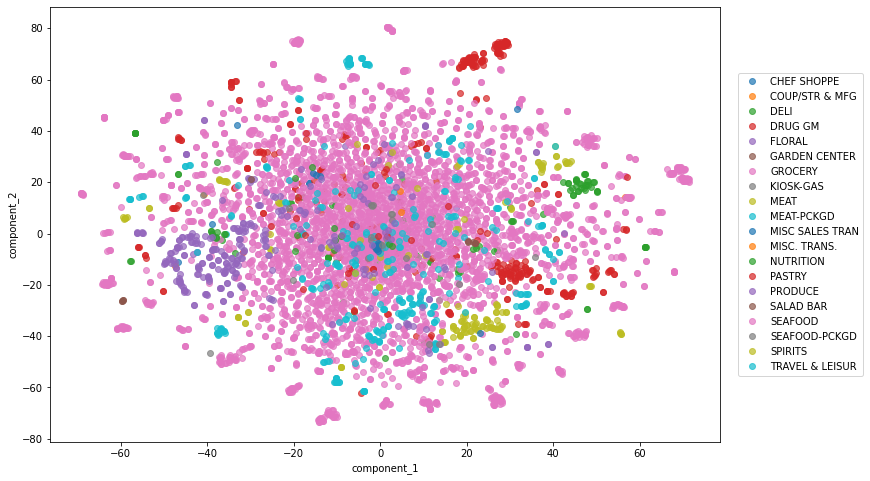

Wall time: 24.4 s


In [156]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

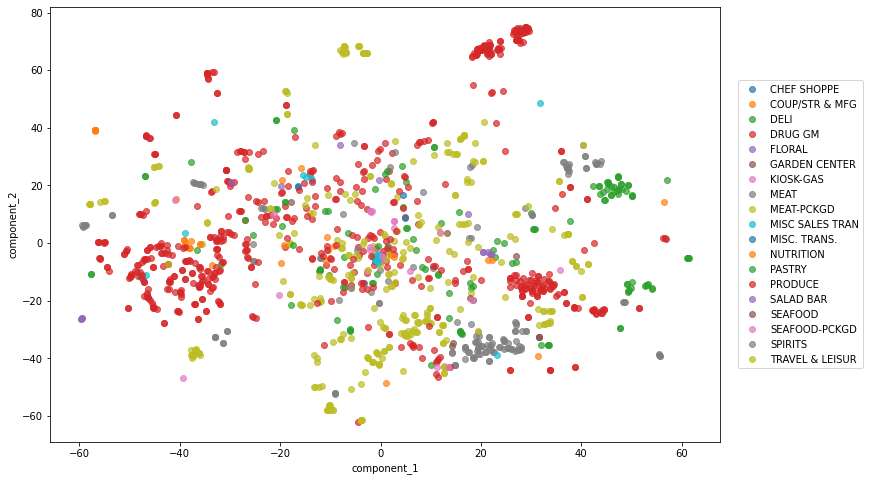

In [157]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

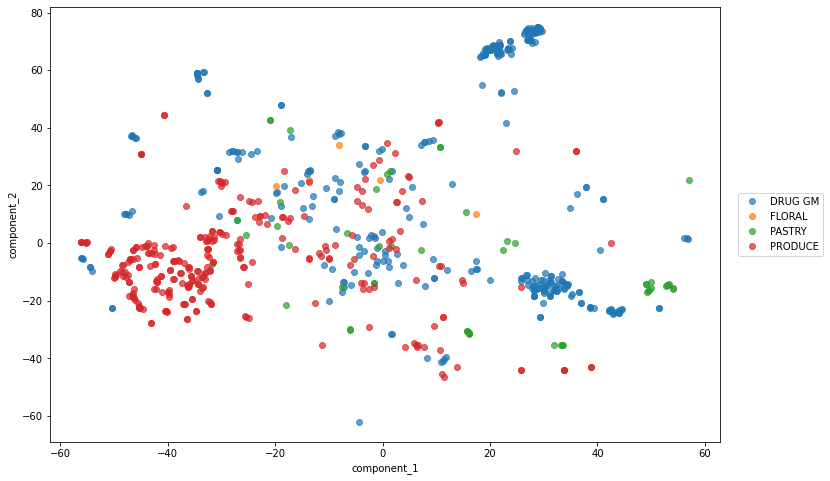

In [158]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

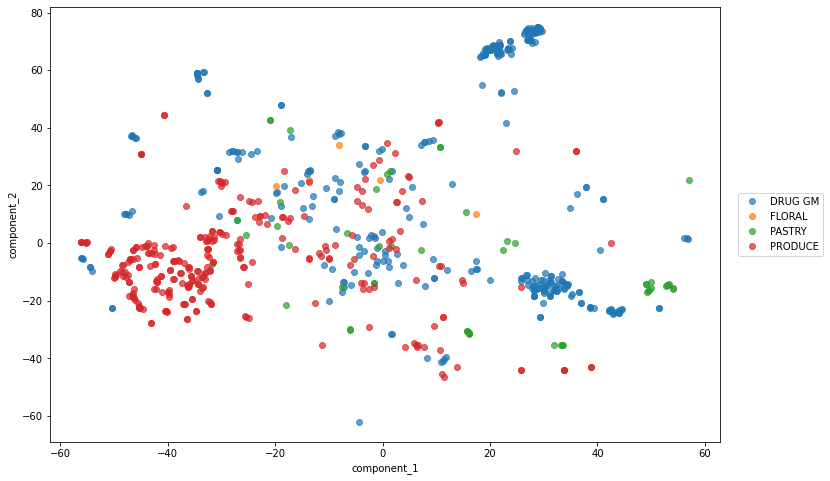

In [159]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

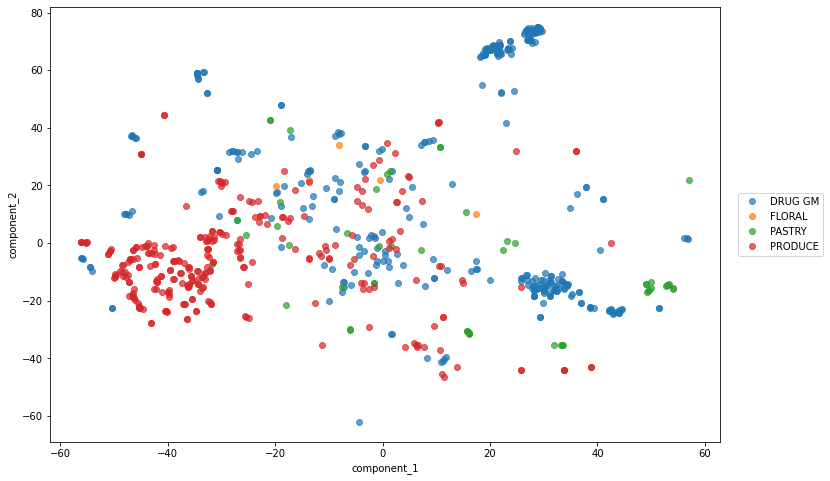

In [160]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

**Вывод**: модель выучила похожесть только небольшой части товаров

In [161]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-0.827307,-5.830962,MISC SALES TRAN
1,0.497987,-5.782156,KIOSK-GAS


### 2.5. Рекоммендации похожих товаров

recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [162]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)


Wall time: 22 s


In [163]:
recommendations.shape

(2499, 5)

In [164]:
pd.DataFrame(recommendations)

,0,1,2,3,4
0,832,192,1927,3947,3616
1,2148,2307,215,391,1086
2,1242,558,1516,3029,3388
3,3408,1801,2148,3587,4346
4,3408,2148,3133,2307,4346
...,...,...,...,...,...
2494,2434,2472,1927,1923,4287
2495,1419,225,3301,2765,2903
2496,3587,4346,3397,2148,558
2497,2847,300,578,1927,1908


In [165]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

*Посмотрите также / Похожие товары*

In [166]:
example_item_row_id = 3606

In [167]:
model.similar_items(example_item_row_id, N=5)

[(3606, 1.0000001),
 (2255, 0.7179771),
 (3537, 0.7105463),
 (5, 0.69924474),
 (3764, 0.69687754)]

In [168]:
#реальные id ближайших товаров
closest_items = [id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]
closest_items

[1100265, 990804, 1094262, 707683, 1113385]

In [169]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
5246,707683,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
36883,1094262,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,1.75 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
39005,1113385,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,13 OZ


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [170]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0),
 (239, 0.9753568),
 (1380, 0.97524756),
 (354, 0.97416246),
 (1627, 0.9718539)]

## 3. Взвешивание <a class="anchor" id="part3"></a><center>

Исследуем величину метрики качетва модели при различных значениях весов в матрице предпочтений

### 3.1. TF-IDF взвешивание

In [171]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [172]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [173]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

tfidf_metric = result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()
tfidf_metric


Wall time: 29.6 s


0.18540646425073193

### 3.2. BM25 взвешивание

In [174]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [175]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [176]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))


Wall time: 29.1 s


In [177]:
bm25_metric = result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
bm25_metric

0.22164544564152502

In [178]:
result.head(3)

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 1005186, 995242, 979707, 986912]","[986912, 965766, 1033142, 995242, 1082185]","[1082185, 995242, 1051211, 1135694, 965766]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 914190, 822407, 938700]","[951590, 910032, 1106523, 9337581, 1133018]","[1053690, 1133018, 951590, 1092026, 965766]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[923746, 878996, 866211, 930118, 1024306]","[1051516, 1023720, 1007195, 866211, 878996]","[1082185, 1098248, 1023720, 1051516, 1024306]"


Сводная таблица с полученными метриками (оптимизация весов)

In [179]:
metrics_weight = pd.DataFrame({'ALS': [als_metric], 'ALS_tfidf': [tfidf_metric],'ALS_bm25': [bm25_metric]}, index = {'precision@5'})
metrics_weight

,ALS,ALS_tfidf,ALS_bm25
precision@5,0.182958,0.185406,0.221645


Лучший показатель метрики у модели 'ALS_bm25', будем настраивать ее гиперпараметры

## 4. Поиск оптимальных параметров ALS <a class="anchor" id="part4"></a><center>

### 4.1. Поиск оптимальных значений factors и iterations

In [180]:
# создаем и взвешиваем матрицу предпочтений
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix = bm25_weight(user_item_matrix.T).T 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [181]:
from itertools import product

#сетка с параметрами
factors=[100, 150, 200, 250]
iterations=[20,50, 100]

def grid_search(result, factors, iterations, regularizations=0.001):
    metrics_grig_search = {}
    for i in range(len(list(product(factors,iterations)))):
        model = AlternatingLeastSquares(factors=list(product(factors,iterations))[i][0], 
                                regularization=regularizations,
                                iterations=list(product(factors,iterations))[i][1], 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        result[f'als_factors={list(product(factors,iterations))[i][0]},_iter={list(product(factors,iterations))[i][1]}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        metrics_grig_search[f'als_factors={list(product(factors,iterations))[i][0]},_iter={list(product(factors,iterations))[i][1]}'] = result.apply(lambda row: precision_at_k(row[f'als_factors={list(product(factors,iterations))[i][0]},_iter={list(product(factors,iterations))[i][1]}'], row['actual']), axis=1).mean()
    
    return result, metrics_grig_search

In [182]:
result, metrics_grig_search = grid_search(result, factors, iterations, regularizations=0.001)

In [183]:
metrics_grig_search

{'als_factors=100,_iter=20': 0.21949069539666693,
 'als_factors=100,_iter=50': 0.21900097943192698,
 'als_factors=100,_iter=100': 0.22056807051909597,
 'als_factors=150,_iter=20': 0.22801175318315112,
 'als_factors=150,_iter=50': 0.23046033300685306,
 'als_factors=150,_iter=100': 0.23085210577864532,
 'als_factors=200,_iter=20': 0.2312438785504376,
 'als_factors=200,_iter=50': 0.22987267384916427,
 'als_factors=200,_iter=100': 0.2272282076395661,
 'als_factors=250,_iter=20': 0.22311459353574659,
 'als_factors=250,_iter=50': 0.2222331047992136,
 'als_factors=250,_iter=100': 0.2224289911851097}

In [184]:
pd.DataFrame(metrics_grig_search, index = {'precision@5'})

,"als_factors=100,_iter=20","als_factors=100,_iter=50","als_factors=100,_iter=100","als_factors=150,_iter=20","als_factors=150,_iter=50","als_factors=150,_iter=100","als_factors=200,_iter=20","als_factors=200,_iter=50","als_factors=200,_iter=100","als_factors=250,_iter=20","als_factors=250,_iter=50","als_factors=250,_iter=100"
precision@5,0.219491,0.219001,0.220568,0.228012,0.23046,0.230852,0.231244,0.229873,0.227228,0.223115,0.222233,0.222429


In [185]:
#поиск оптимальных параметров
max_val = max(metrics_grig_search.values())
opt_params = {k:v for k, v in metrics_grig_search.items() if v == max_val}

print('Оптимальные параметры: ')
opt_params

Оптимальные параметры: 


{'als_factors=200,_iter=20': 0.2312438785504376}

In [186]:
best_model = AlternatingLeastSquares(factors=200, 
                                regularization=0.001,
                                iterations=20, 
                                calculate_training_loss=True, 
                                num_threads=4)

### 4.2. Поиск оптимальных значений regularizations

In [187]:
#сетка с параметрами
regularizations = [0.01, 0.001, 0.0001]

def grid_search_reg(result, regularizations):
    metrics_grig_search_reg = {}
    for i in range(len(regularizations)):
        
        model = AlternatingLeastSquares(factors=200, 
                                regularization=regularizations[i],
                                iterations=20, 
                                calculate_training_loss=True, 
                                num_threads=4)
        
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        result[f'als_reg={regularizations[i]}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        metrics_grig_search_reg[f'als_reg={regularizations[i]}'] = result.apply(lambda row: precision_at_k(row[f'als_reg={regularizations[i]}'], row['actual']), axis=1).mean()
    
    return result, metrics_grig_search_reg

In [189]:
result, metrics_grig_search_reg = grid_search_reg(result, regularizations)

In [191]:
metrics_grig_search_reg

{'als_reg=0.01': 0.23398628795298423,
 'als_reg=0.001': 0.22977473065621679,
 'als_reg=0.0001': 0.22948090107737185}

In [193]:
#поиск оптимальных параметров
max_val_reg = max(metrics_grig_search_reg.values())
opt_params_reg = {k:v for k, v in metrics_grig_search_reg.items() if v == max_val_reg}

print('Оптимальные параметры: ')
opt_params_reg

Оптимальные параметры: 


{'als_reg=0.01': 0.23398628795298423}

In [194]:
best_model = AlternatingLeastSquares(factors=200, 
                                regularization=0.01,
                                iterations=20, 
                                calculate_training_loss=True, 
                                num_threads=4)

## 5. Production <a class="anchor" id="part5"></a><center>

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией**

**Как это учесть?** если товар участвует в акции, то в user-item матрицу помещаем вес = цена товара - сумма скидки .

**Если процент скидки менялся**, то в user-item матрице указываем вес = цена товара - сумма последней скидки.

- **1 новый товар** (юзер никогда не покупал). 

**Как определить новый товар для рекоммендаций?** 
1) делаем рекоммендации на товарах, которые пользователь еще не покупал; получаем рекомендации и выбираем из них товар с наибольшим скором.

2) можно среди покупок пользователя найти похожие товары; выбрать из них те, которые пользователь еще не покупал; сделать рекомендации на таких товарах и выбрать товар с наибольшим скором.

3) можно найти покупателей похожих на данного покупателя, собрать все их покупки; отобрать среди покупок те, которые данный пользователь еще не покупал; сделать рекомендации на таких товарах и выбрать товар с наибольшим скором.

**Если у нового товара очень маленькая вероятность покупки** можно поискать похожие на него товары.


- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер). 

**Как измерить "минимум дороже"?** цена рекоммендуемого товара должна быть на 3% больше среднего товра в чеке.

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [197]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [198]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train.head(3)

<ipython-input-198-394ac6eb75cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0,0.99


In [202]:
data_train['price'].describe()

count    2.278490e+06
mean     2.412506e+00
std      2.704008e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.890000e+00
75%      2.990000e+00
max      4.999900e+02
Name: price, dtype: float64

In [199]:
#максимальная цена дешевых товаров
# < 1$
data_train['price'].quantile(0.20)

0.99

In [200]:
#минимальная цена дорогих товаров
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [53]:
def prefilter_items(data):    
    # Уберем самые популярные товары (их и так купят)
    # количество уникальных пользователей, купивших этот товар / общее количество уникальных пользователей
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    year_data = data[data['week_no'] > data['week_no'].max() - 52]
    
    no_quantity_year_items = year_data[year_data['quantity'] == 0].item_id.tolist()
    
    data = data[~data['item_id'].isin(no_quantity_year_items)]
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    too_cheap_items = data[data['price'] < data['price'].quantile(0.20)].item_id.tolist()
    
    data = data[~data['item_id'].isin(too_cheap_items)]
    
    # Уберем слишком дорогие товары
    
    too_expensive_items = data[data['price'] > data['price'].quantile(0.99995)].item_id.tolist()
    
    data = data[~data['item_id'].isin(too_expensive_items)]
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

Cтатьи BM25/MatrixFactorization

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters

https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/